In [12]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import glob
import seaborn as sns

from PIL import Image
from scipy import ndimage


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC
from sklearn.utils import compute_class_weight



%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.mymods import Vis_results, Vis_results_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Constants across all models
train_dir = '../../src/data2/train'
val_dir = '../../src/data2/val'
test_dir = '../../src/data2/test'

num_of_test_samples = len(glob.glob('../../src/data2/test/*/*.jpg'))
batch_size = 64
target_size = (176, 208)

# Rescales the pixel values between 0 and 1 so keras can work with it
# Not going to use image Augmentation as results were high enough without
dagenerator = ImageDataGenerator(rescale=1./255)

train_generator  = dagenerator.flow_from_directory(directory = train_dir,
                                                   target_size = target_size,
                                                   batch_size = batch_size)

val_generator = dagenerator.flow_from_directory(directory = val_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  batch_size = batch_size)

test_generator = dagenerator.flow_from_directory(directory = test_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  batch_size = num_of_test_samples)

# Large imbalance of classes so using a class weight dictionary instead of oversampling
class_weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
dict_class_weights = dict(enumerate(class_weights));
print(f' Class weights: {dict_class_weights}');

Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
Found 961 images belonging to 4 classes.
 Class weights: {0: 1.7858851674641147, 1: 25.448863636363637, 2: 0.49988839285714287, 3: 0.7141262755102041}


In [6]:
# First basic model using Conv2D layers, pooling and Dense layers
# Taken from Model_new_tvt, but increased target size to 176, 208
model = Sequential()

model.add(Conv2D(10, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify

# Going to use RMS for model as it was best results
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(learning_rate = 1e-4),
              metrics= ['acc', 'AUC'])


#Fit perameters
earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15,
                              restore_best_weights= True,
                              verbose = 1)

filepath = '../../src/best_weights_mod1.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callbacks = [earlystopping, checkpoint]

history = model.fit_generator(
        generator =train_generator,
        validation_data = val_generator,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=200)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 1.3838 - acc: 0.2795 - auc: 0.5738
Epoch 00001: val_acc improved from -inf to 0.45881, saving model to ../../src/best_weights_mod1.hdf5
70/70 [==============================] - 43s 609ms/step - loss: 1.3838 - acc: 0.2795 - auc: 0.5738 - val_loss: 1.3672 - val_acc: 0.4588 - val_auc: 0.6613
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 1.3271 - acc: 0.4407 - auc: 0.7053
Epoch 00002: val_acc improved from 0.45881 to 0.48071, saving model to ../../src/best_weights_mod1.hdf5
70/70 [==============================] - 57s 816ms/step - loss: 1.3271 - acc: 0.4407 - auc: 0.7053 - val_loss: 1.2667 - val_acc: 0.4807 - val_auc: 0.7583
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 1.2298 - acc: 0.5095 - auc: 0.7679
Epoch 00003: val_acc did not improve from 0.48071
70/70 [==============================] - 51s 725m

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 174, 206, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 87, 103, 10)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 101, 20)       1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 50, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 48, 20)        3620      
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [7]:
# 2nd model using Conv2D layers, pooling and Dense, dropout layers 
# Added a larger amount of nodes and dense layer
model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(.5))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dropout(.5))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dropout(.25))
model_2.add(Dense(4, activation='softmax'))

# Going to use RMS for model as it was best results
model_2.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(learning_rate = 1e-4),
              metrics= ['acc', 'AUC'])


#Fit perameters
earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15,
                              restore_best_weights= True,
                              verbose = 1)

filepath = '../../src/best_weights_mod2.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callbacks = [earlystopping, checkpoint]

history_2 = model_2.fit_generator(
        generator =train_generator,
        validation_data = val_generator,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=200)

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 1.4328 - acc: 0.2965 - auc: 0.5452
Epoch 00001: val_acc improved from -inf to 0.50052, saving model to ../../src/best_weights_mod2.hdf5
70/70 [==============================] - 126s 2s/step - loss: 1.4328 - acc: 0.2965 - auc: 0.5452 - val_loss: 1.3159 - val_acc: 0.5005 - val_auc: 0.7218
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 1.3873 - acc: 0.3481 - auc: 0.5943
Epoch 00002: val_acc improved from 0.50052 to 0.51616, saving model to ../../src/best_weights_mod2.hdf5
70/70 [==============================] - 126s 2s/step - loss: 1.3873 - acc: 0.3481 - auc: 0.5943 - val_loss: 1.3400 - val_acc: 0.5162 - val_auc: 0.7352
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 1.3891 - acc: 0.3340 - auc: 0.6040
Epoch 00003: val_acc did not improve from 0.51616
70/70 [==============================] - 125s 2s/step - loss: 1.3891 - acc: 0.3340 - auc: 0.6040 - val_loss: 1.3690 - val_acc: 0.

In [8]:
# 3rd model using Conv2D layers, pooling and Dense, dropout layers
# Similar to model 2, but less nodes and dense layer
model_3 = Sequential()

model_3.add(Conv2D(16, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model_3.add(MaxPooling2D((2,2)))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(.25))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(.25))
model_3.add(Dense(4, activation='softmax')) 

# Trying RMSprop on its own without giving it a learning rate. 
model_3.compile(loss='categorical_crossentropy', 
              optimizer='RMSprop',
              metrics= ['acc', 'AUC'])

#Fit perameters
earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15,
                              restore_best_weights= True,
                              verbose = 1)

filepath = '../../src/best_weights_mod3.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callbacks = [earlystopping, checkpoint]

history_3 = model_3.fit_generator(
        generator =train_generator,
        validation_data = val_generator,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=200)

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 1.6795 - acc: 0.3166 - auc: 0.5633
Epoch 00001: val_acc improved from -inf to 0.45047, saving model to ../../src/best_weights_mod3.hdf5
70/70 [==============================] - 54s 772ms/step - loss: 1.6795 - acc: 0.3166 - auc: 0.5633 - val_loss: 1.3803 - val_acc: 0.4505 - val_auc: 0.6751
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 1.3973 - acc: 0.3391 - auc: 0.6029
Epoch 00002: val_acc did not improve from 0.45047
70/70 [==============================] - 54s 770ms/step - loss: 1.3973 - acc: 0.3391 - auc: 0.6029 - val_loss: 1.3762 - val_acc: 0.1960 - val_auc: 0.6426
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 1.3936 - acc: 0.3170 - auc: 0.5728
Epoch 00003: val_acc improved from 0.45047 to 0.48279, saving model to ../../src/best_weights_mod3.hdf5
70/70 [==============================] - 54s 768ms/step - loss: 1.3936 - acc: 0.3170 - auc: 0.5728 - val_loss: 1.3410 - val_a

In [9]:
# Model 4 uses greyscale so the layers input shape will have to be different than the other models
# 3 new generators are greated for this purpose 

train_generator_gs  = dagenerator.flow_from_directory(directory = train_dir,
                                                   target_size = target_size,
                                                   color_mode="grayscale",
                                                   batch_size = batch_size)

val_generator_gs = dagenerator.flow_from_directory(directory = val_dir,
                                                  target_size = target_size,
                                                  color_mode="grayscale",
                                                  shuffle = False,
                                                  batch_size = batch_size)

test_generator_gs = dagenerator.flow_from_directory(directory = test_dir,
                                                  target_size = target_size,
                                                  color_mode="grayscale",
                                                  shuffle = False,
                                                  batch_size = num_of_test_samples)



# Added more nodes because of the single layer and some padding and strides along with it
model_4 = Sequential()

model_4.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
               strides=(2,2), input_shape = (target_size[0],target_size[1],1)))
model_4.add(MaxPooling2D(2))
model_4.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_4.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_4.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_4.add(MaxPooling2D(2))
model_4.add(Flatten())
model_4.add(Dense(64, activation = 'relu'))
model_4.add(Dropout(0.4))
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dropout(0.4))
model_4.add(Dense(4, activation = 'softmax'))
               
               
model_4.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(learning_rate = 1e-4),
              metrics= ['acc', 'AUC'])

# Fit parameters 

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15,
                              restore_best_weights= True,
                              verbose = 1)

filepath = '../../src/best_weights_mod4.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]


history_4 = model_4.fit_generator(
        generator =train_generator_gs,
        validation_data = val_generator_gs,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=200)

Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
Found 961 images belonging to 4 classes.
Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 1.3885 - acc: 0.3273 - auc: 0.5601
Epoch 00001: val_acc improved from -inf to 0.02607, saving model to ../../src/best_weights_mod4.hdf5
70/70 [==============================] - 69s 991ms/step - loss: 1.3885 - acc: 0.3273 - auc: 0.5601 - val_loss: 1.3946 - val_acc: 0.0261 - val_auc: 0.2905
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 1.3867 - acc: 0.3123 - auc: 0.5577
Epoch 00002: val_acc improved from 0.02607 to 0.50052, saving model to ../../src/best_weights_mod4.hdf5
70/70 [==============================] - 69s 988ms/step - loss: 1.3867 - acc: 0.3123 - auc: 0.5577 - val_loss: 1.3553 - val_acc: 0.5005 - val_auc: 0.7927
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 1.3877 - acc: 0.3103 - auc: 0.5756
Epoch 00003: val_acc improved from 0.50052 to 0.502

# Results of the 4 Models

In [10]:
# Pull in best weights from model iteration
model = load_model('../../src/best_weights_mod1.hdf5')
model_2 = load_model('../../src/best_weights_mod2.hdf5')
model_3 = load_model('../../src/best_weights_mod3.hdf5')
model_4 = load_model('../../src/best_weights_mod4.hdf5')

### Model 1 Results

Instructions for updating:
Please use Model.predict, which supports generators.
-----------------------Val Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.98      0.99      0.98       134
    Moderate       1.00      1.00      1.00         9
        None       0.99      0.98      0.98       480
   Very Mild       0.97      0.98      0.97       336

    accuracy                           0.98       959
   macro avg       0.98      0.99      0.98       959
weighted avg       0.98      0.98      0.98       959

------------------------Val Confusion Matrix---------------------------


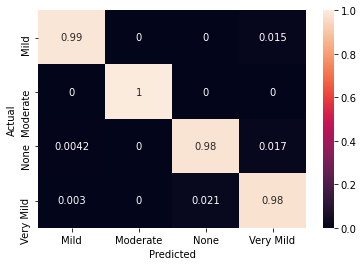

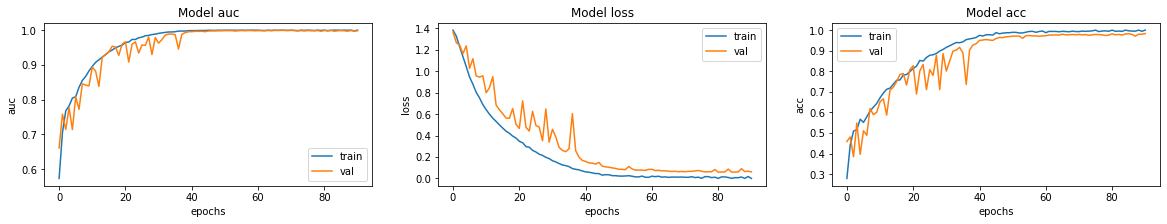

In [13]:
# Validation results
Vis_results(model, history, val_generator, val_generator.n, batch_size)

-----------------------Test Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.98      0.94      0.96       135
    Moderate       1.00      1.00      1.00        11
        None       0.99      0.96      0.98       480
   Very Mild       0.94      0.99      0.96       335

    accuracy                           0.97       961
   macro avg       0.98      0.97      0.97       961
weighted avg       0.97      0.97      0.97       961

------------------------Test Confusion Matrix---------------------------


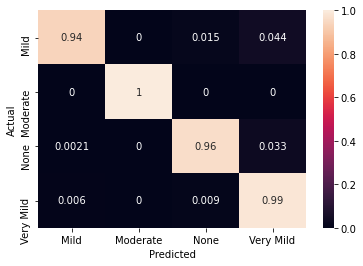

In [29]:
# test results
y_pred_mod1 = Vis_results_test(model, history, test_generator)

In [64]:
import json
with open('../../src/history_mod1.json', 'w') as f:
    json.dump(history.history, f)

### Model 2 results

-----------------------Val Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.99      0.99      0.99       134
    Moderate       0.90      1.00      0.95         9
        None       0.98      0.98      0.98       480
   Very Mild       0.97      0.97      0.97       336

    accuracy                           0.98       959
   macro avg       0.96      0.99      0.97       959
weighted avg       0.98      0.98      0.98       959

------------------------Val Confusion Matrix---------------------------


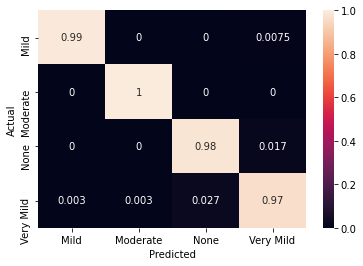

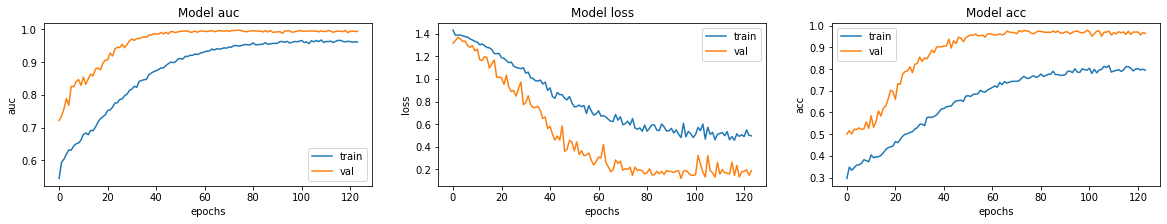

In [65]:
# Validation results
Vis_results(model_2, history_2, val_generator, val_generator.n, batch_size)

-----------------------Test Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.97      0.93      0.95       135
    Moderate       1.00      1.00      1.00        11
        None       0.98      0.97      0.98       480
   Very Mild       0.94      0.97      0.96       335

    accuracy                           0.97       961
   macro avg       0.97      0.97      0.97       961
weighted avg       0.97      0.97      0.97       961

------------------------Test Confusion Matrix---------------------------


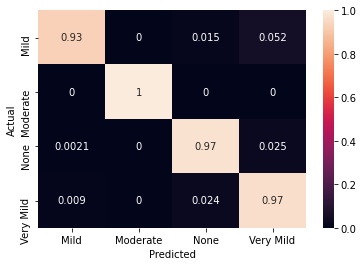

In [17]:
# Test results
Vis_results_test(model_2, history_2, test_generator)

### Model 3 results

-----------------------Val Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.99      0.97      0.98       134
    Moderate       1.00      1.00      1.00         9
        None       0.99      0.97      0.98       480
   Very Mild       0.95      0.98      0.96       336

    accuracy                           0.97       959
   macro avg       0.98      0.98      0.98       959
weighted avg       0.98      0.97      0.98       959

------------------------Val Confusion Matrix---------------------------


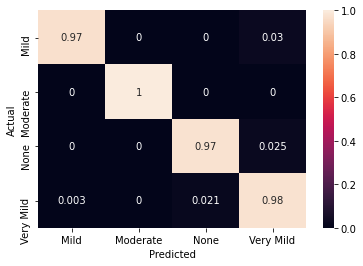

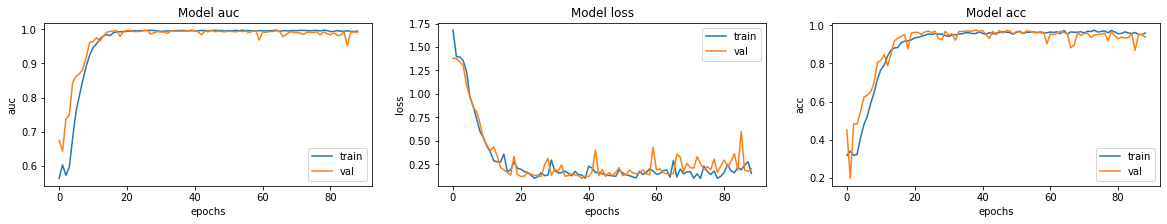

In [19]:
Vis_results(model_3, history_3, val_generator, val_generator.n, batch_size)

-----------------------Test Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.97      0.93      0.95       135
    Moderate       1.00      1.00      1.00        11
        None       0.99      0.97      0.98       480
   Very Mild       0.93      0.97      0.95       335

    accuracy                           0.96       961
   macro avg       0.97      0.97      0.97       961
weighted avg       0.97      0.96      0.96       961

------------------------Test Confusion Matrix---------------------------


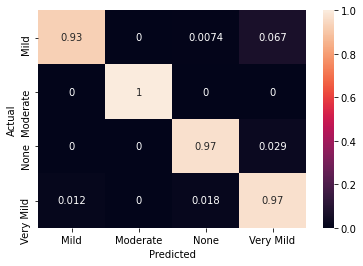

In [20]:
Vis_results_test(model_3, history_3, test_generator)

### Model 4 Results

-----------------------Val Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.99      0.99      0.99       134
    Moderate       1.00      1.00      1.00         9
        None       0.99      1.00      0.99       480
   Very Mild       0.99      0.98      0.99       336

    accuracy                           0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959

------------------------Val Confusion Matrix---------------------------


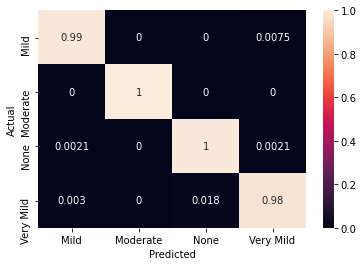

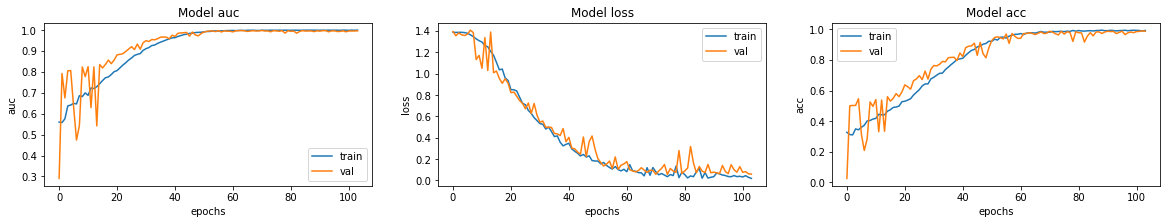

In [21]:
Vis_results(model_4, history_4, val_generator_gs, val_generator_gs.n, batch_size)

-----------------------Test Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.96      0.98      0.97       135
    Moderate       1.00      1.00      1.00        11
        None       0.98      0.98      0.98       480
   Very Mild       0.97      0.96      0.97       335

    accuracy                           0.97       961
   macro avg       0.98      0.98      0.98       961
weighted avg       0.97      0.97      0.97       961

------------------------Test Confusion Matrix---------------------------


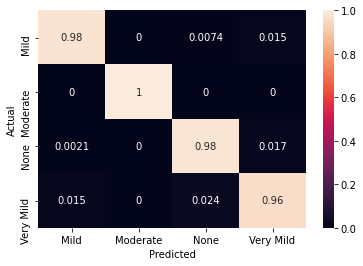

In [22]:
Vis_results_test(model_4, history_4, test_generator_gs)

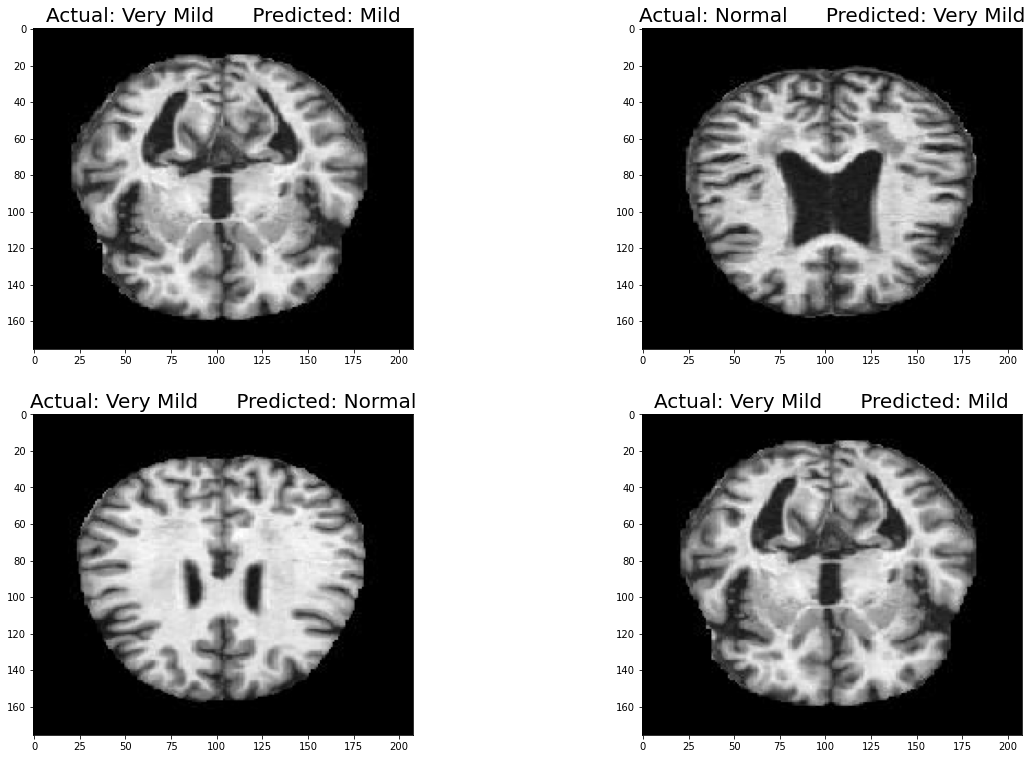

In [57]:
# the Indices of the labels that were incorrect    
incorrects = np.nonzero(y_pred_mod1 != test_generator.classes)[0]     

ncols=2
nrows=2

a, b = test_generator[0]    
# shows us a random assortment of what our model got wrong    
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (20,13))
for row in range(axs.shape[0]):
    for col in range(axs.shape[1]):
        for i in np.random.choice(incorrects, ncols):
            img = a[i]
            class_name = ['Mild', 'Moderate', 'Normal', 'Very Mild']
            act_classname = class_name[test_generator.classes[i]]
            pred_classname = class_name[y_pred_mod1[i]]

            axs[row,col].imshow(img)
            axs[row,col].set_title(f'Actual: {act_classname}      Predicted: {pred_classname}', fontsize = 20)